In [1]:
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
rng = np.random.RandomState(72)

TODO

In [2]:
data = None
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/character-trajectories/mixoutALL_shifted.mat'

try:
    path = os.path.join(os.getcwd(), 'temp.mat')
    response = requests.get(url)
except:
    raise
else:
    with open(path, 'wb') as file:
        file.write(response.content)
        data = loadmat(path)
finally:
    os.remove(path)

In [3]:
# Load the trajectories
X = [x.T for x in data['mixout'][0]]
print('Number of trajectories: {}'.format(len(X)))

Number of trajectories: 2858


Only lowercase characters with a single pen-down segment were considered in this dataset. In total, there were 20 of these characters as shown below:

In [4]:
# Retrieve the set of unique labels and report the number of labels
labels = [label[0] for label in data['consts'][0][0][3][0]]
n_labels = len(labels)
print('Labels: {}'.format(str(labels)))
print('Number of labels: {}'.format(n_labels))

Labels: ['a', 'b', 'c', 'd', 'e', 'g', 'h', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'y', 'z']
Number of labels: 20


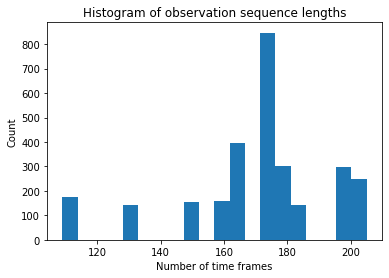

In [5]:
# View distribution of observation sequence lengths
plt.title('Histogram of observation sequence lengths')
plt.xlabel('Number of time frames')
plt.ylabel('Count')
plt.hist([len(x) for x in X], bins=n_labels)
plt.show()

The sample rate of each trajectory recording was 200hz–meaning that in every second, 200 pen-tip trajectories were recorded!

As seen in the histogram above, most characters can be drawn in less than 200 frames, or in less than one second.

Although keeping all of these frames/data-points might result in a more accurate classifier, it also significantly increases the time required for training or prediction. This is especially the case for $k$NN, since it is a non-parametric classifier that requires going through each training example during prediction time.

---

There are two features offered by Sequentia that can help to reduce this issue:

- Downsampling (summarizing each trajectory in a fewer number of frames) through two different methods:
  - **Decimation**: Only keeping the observation at every every $n$th time frame.
  - **Averaging**: Averaging every group of $n$ observations to form a singe observation.
- Using a faster, restricted distance measure that can handle sequences of different length (see [FastDTW](https://pdfs.semanticscholar.org/05a2/0cde15e172fc82f32774dd0cf4fe5827cad2.pdf))

The `DTWKNN` class always uses the FastDTW algorithm to calculate distances. Downsampling is offered as one of the preprocessing methods in Sequentia, and is used as follows (see the _Preprocessing_ notebook for more information):

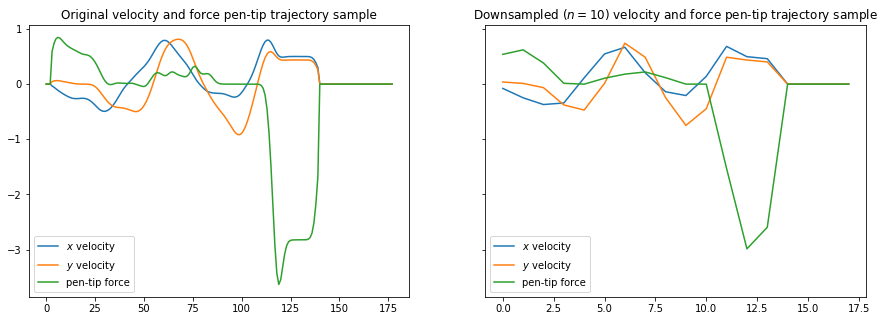

In [6]:
from sequentia.preprocessing import downsample

# Pick an example trajectory for visualization
x = X[0]
# Downsample the example trajectory, using a downsample factor of n=10
x_down = downsample(x, n=10, method='average')

# Create the plot to visualize the downsampling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.plot(x)
ax1.set_title('Original velocity and force pen-tip trajectory sample')
ax1.legend(labels=['$x$ velocity', '$y$ velocity', 'pen-tip force'])
ax2.plot(x_down)
ax2.set_title('Downsampled ($n=10$) velocity and force pen-tip trajectory sample')
ax2.legend(labels=['$x$ velocity', '$y$ velocity', 'pen-tip force'])
plt.show()

In [7]:
# Downsample the entire dataset
X = downsample(X, n=10, method='average')

TODO

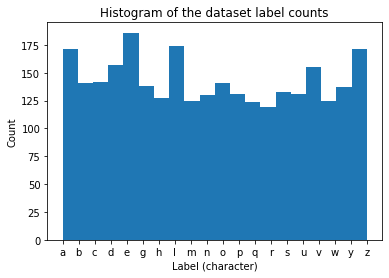

In [8]:
# Extract the labels
y = [labels[idx - 1] for idx in data['consts'][0][0][4][0]]

# Plot a histogram of the labels for each class
plt.title('Histogram of the dataset label counts')
plt.xlabel('Label (character)')
plt.ylabel('Count')
plt.hist(y, bins=n_labels)
plt.show()

In [9]:
# Shuffle and split the dataset into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng, shuffle=True)
print('Training set size: {}'.format(len(X_train)))
print('Test set size: {}'.format(len(X_test)))

Training set size: 2000
Test set size: 858


In [10]:
# Create a function for displaying results (accuracy and confusion matrix)
def show_results(acc, cm, dataset):
    df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df, annot=True)
    plt.title('Confusion matrix for {} set predictions'.format(dataset), fontsize=14)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # Fix for matplotlib bug that cuts off top/bottom of seaborn visualizations
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.show()
    print('Accuracy: {:.2f}%'.format(acc * 100))

## Dynamic Time Warping $k$-NN

TODO

---

Importing, creating and fitting the classifier:

In [11]:
from sequentia.classifiers import DTWKNN

# Create and fit a DTWKNN classifier using the single nearest neighbor and a radius of 1
# NOTE: The radius parameter is a parameter that constrains the FastDTW algorithm.
clf = DTWKNN(k=1, radius=1)
clf.fit(X_train, y_train)

To predict single or multiple examples, we can use the `predict` function.

In [12]:
# Predict the first test example
clf.predict(X_test[0])

Calculating distances: 100%|██████████| 2000/2000 [00:11<00:00, 179.42it/s]


'd'

In [13]:
# Predict the first 5 test examples
clf.predict(X_test[:5])

Classifying examples: 100%|██████████| 5/5 [00:48<00:00,  9.74s/it]


['d', 'r', 'c', 'l', 's']

To calculate the model's accuracy and confusion matrix on some data, we can use the `evaluate` function.

In [14]:
acc, cm = clf.evaluate(X_test, y_test, labels=labels)

Classifying examples: 100%|██████████| 858/858 [2:42:01<00:00, 11.33s/it]  


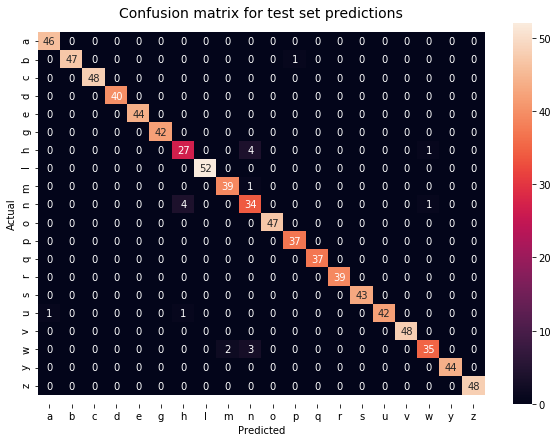

Accuracy: 97.79%


In [15]:
show_results(acc, cm, dataset='test')

As you can see, Dynamic Time Warping $k$-NN classification often works with near perfect performance, but suffers due to the fact that $k$-NN is a non-parametric machine learning algorithm. 

This means that we have to look through every training example when we make a single prediction. Even with FastDTW and downsampling, the example classification on the test set consisting of 858 examples took over two and a half hours!

---

As a result, parametric methods such as Hidden Markov Models are often more feasible to use–but also generally perform worse.

## Ensemble Hidden Markov Models

In [16]:
from sequentia.classifiers import HMM, HMMClassifier

hmms = []
for label in tqdm(labels, desc="Training HMMs"):
    hmm = HMM(label=label, n_states=10)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    hmm.fit([X_train[i] for i, y_i in enumerate(y_train) if y_i == label])
    hmms.append(hmm)

Training HMMs: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


In [17]:
clf = HMMClassifier()
clf.fit(hmms)

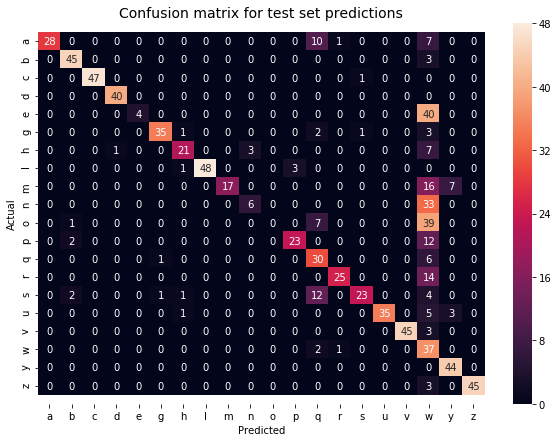

Accuracy: 69.70%


In [18]:
acc, cm = clf.evaluate(X_test, y_test, labels=labels)
show_results(acc, cm, dataset='test')